# Bi-layer SiN edge coupler in the visible frequency

**Note: the cost of running the entire notebook is around 20 FlexCredits.**

Photonic integrated circuits that operate at visible wavelengths (400-700nm) are gaining interest for emerging applications beyond traditional telecommunications. Compared to PICs designed for infrared wavelengths, visible light PICs can potentially enable new applications in spectroscopy, bio-medical imaging, quantum computing, augmented reality, and more. However, efficiently interfacing visible light between optical fibers and nanophotonic components on a chip remains challenging. Due to the shorter wavelengths, photonic waveguides must be smaller to confine light, leading to significant mode mismatch with optical fibers. Efficient coupling techniques like inverse tapers reach the limits of fabrication capabilities at visible wavelengths. Novel solutions are needed to address these challenges in fiber-to-chip coupling for visible light PICs.

In this notebook, we demonstrate a SiN bi-layer edge coupler design for efficient and broadband fiber-to-chip coupling in visible frequency. The design uses a thin top SiN layer for mode field diameter expansion at the facet to improve fiber coupling and a thicker bottom SiN layer for tight mode confinement and routing. The design achieves a coupling loss ≤4 dB over a broad wavelength range, which is 3-5 dB lower compared to conventional single-layer edge couplers. The example is adapted from `Yiding Lin, Jason C. C. Mak, Hong Chen, Xin Mu, Andrei Stalmashonak, Youngho Jung, Xianshu Luo, Patrick G.-Q. Lo, Wesley D. Sacher, and Joyce K. S. Poon, "Low-loss broadband bi-layer edge couplers for visible light," Opt. Express 29, 34565-34576 (2021)` [DOI:10.1364/OE.435669](https://doi.org/10.1364/OE.435669).

<img src="img/bilayer_edge_coupler.png" width="500" alt="Schematic of the edge coupler">

In another case study, we investigate [inverse taper edge couplers](https://www.flexcompute.com/tidy3d/examples/notebooks/EdgeCoupler/) at the telecom frequency. In addition, different grating coupler designs including the [uniform grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/GratingCoupler/), the [focusing apodized grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/FocusedApodGC/), and the [inverse designed compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/) are also explored in various case studies. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

The wavelength range of interest for this edge coupler is 400 nm to 640 nm.

In [2]:
lda0 = 0.52  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(0.4, 0.64, 51)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency

The bi-layer structure is surrounded by a 2 $\mu m$ top SiO$_2$ cladding and a 3$\mu m$ bottom SiO$_2$ layer. We do not model the air region above the top cladding and the silicon region below the SiO$_2$ layer since the mode diameter of the single mode fiber is only about 3.7 $\mu m$. In this case, we first define two materials: SiN and SiO$_2$, both of which are described by a constant refractive index given in the [reference](https://doi.org/10.1364/OE.435669). Using non-dispersive media also helps to reduce the computational cost. 

Based on the [reference](https://doi.org/10.1364/OE.435669), the optical fiber used is a Nufern S405-XP single-mode fiber, which has a core diameter of 3 $\mu m$ and a numerical aperture (NA) of 0.12. Here we assume The cladding material is the same SiO$_2$ and calculate the core refractive index based on the NA and $n_{SiO_2}$. 

In [3]:
n_SiN = 1.82  # silicon nitride refractive index
SiN = td.Medium(permittivity=n_SiN**2)

n_SiO2 = 1.46  # silicon oxide refractive index
SiO2 = td.Medium(permittivity=n_SiO2**2)

NA = 0.12  # numerical aperture of the optical fiber
n_core = np.sqrt(NA**2 + n_SiO2**2)  # fiber core refractive index
core_mat = td.Medium(permittivity=n_core**2)

Next we define the geometric parameters of the edge coupler. The physical meanings of the parameters are schematically shown in Fig.1 of the [publication](https://doi.org/10.1364/OE.435669). We assume a 500 nm air gap between the optical fiber facet to the beginning of the edge coupler.

In [4]:
W_EC = 0.15  # width of the tip of the edge coupler
W_base = 1  # width of the base
W_tip1 = 0.15  # width of the tip of the bottom SiN
W_tip2 = 0.15  # width of the tip of the top SiN
W_wg = 0.38  # width of the straight SiN waveguide
L_EC = 200  # length of the edge coupler
L_tran = 75  # length of the transition region
t_1 = 0.15  # thickness of the bottom SiN
t_2 = 0.075  # thickness of the top SiN
t_space = 0.1  # spacing between the two SiN layers
buffer = 3  # buffer spacing
r_core = 1.5  # radius of the fiber core
l_fiber = 10  # length of the fiber
gap = 0.5  # air gap size between the fiber and edge coupler

Given the shapes of the SiN layers, the most convenient way to define them is by using [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html). The vertices can be easily calculated from the geometric parameters defined above.

In [5]:
# define vertices for the bottom SiN
vertices = [
    (L_EC, -W_tip1 / 2),
    (L_EC + L_tran, -W_wg / 2),
    (L_EC + L_tran + 2 * buffer, -W_wg / 2),
    (L_EC + L_tran + 2 * buffer, W_wg / 2),
    (L_EC + L_tran, W_wg / 2),
    (L_EC, W_tip1 / 2),
]
# define the bottom SiN structure
bottom_SiN = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-t_1 / 2, t_1 / 2)), medium=SiN
)

# define vertices for the top SiN
vertices = [
    (0, W_EC / 2),
    (L_EC, W_base / 2),
    (L_EC + L_tran, W_tip2 / 2),
    (L_EC + L_tran, -W_tip2 / 2),
    (L_EC, -W_base / 2),
    (0, -W_EC / 2),
]

# define the top SiN structure
top_SiN = td.Structure(
    geometry=td.PolySlab(
        vertices=vertices, axis=2, slab_bounds=(t_1 / 2 + t_space, t_1 / 2 + t_space + t_2)
    ),
    medium=SiN,
)

# define the SiO2 cladding structure
cladding_SiO2 = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(0, -4 * r_core, -4 * r_core),
        rmax=(L_EC + L_tran + 2 * r_core + buffer, 4 * r_core, 4 * r_core),
    ),
    medium=SiO2,
)

# define the optical fiber core
core_fiber = td.Structure(
    geometry=td.Cylinder(
        axis=0,
        radius=r_core,
        length=l_fiber,
        center=(-l_fiber / 2 - gap, 0, t_1 / 2 + t_space + t_2 / 2),
    ),
    medium=core_mat,
)

# define the optical fiber cladding
cladding_fiber = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-2 * buffer, -4 * r_core, -4 * r_core),
        rmax=(-gap, 4 * r_core, 4 * r_core),
    ),
    medium=SiO2,
)

Since we already know the core radius and the refractive indices of the fiber core and cladding materials, we model the fiber explicitly and then use a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to launch the fiber mode. Alternatively, we can use a [GaussianBeam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianBeam.html) with the same beam size to mimic the fiber mode, as demonstrated in the previous [inverse taper edge couplers](https://www.flexcompute.com/tidy3d/examples/notebooks/EdgeCoupler/) example. We will run two separate simulations to investigate the coupling efficiencies of TE and TM modes. The two polarizations correspond to two different symmetry conditions.

To compute the coupling efficiency, we add a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) at the straight SiN waveguide. Although not necessary, it's still quite helpful to add a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) to visualize the field distribution. Since the simulation domain is quite large, we don't need to store the field at each grid point to have a good field distribution plot. Therefore, we set `interval_space=(3,1,1)` to downsample the stored field by a factor of 3, which helps reduce the size of the downloaded data significantly. 

In [6]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
fiber_mode = td.ModeSource(
    center=(-gap - lda0, 0, t_1 / 2 + t_space + t_2 / 2),
    size=(0, 5 * r_core, 5 * r_core),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# define a mode monitor at the straight SiN waveguide to compute coupling efficiency
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_SiN)
mode_monitor = td.ModeMonitor(
    center=(L_EC + L_tran + buffer / 2, 0, 0),
    size=(0, 4 * W_wg, 6 * t_1),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add a field monitor to visualize field distribution at y=0
field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, 3 * r_core),
    freqs=[freq0],
    interval_space=(3, 1, 1),
    name="field",
)

First we define the simulation with TE polarization. This polarization corresponds to `symmetry=(0,-1,0)`. To learn how to properly utilize symmetry to reduce computational cost, please refer to our [symmetry tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Symmetry/). The simulation domain sizes in the $y$ and $z$ directions need to be sufficiently large to ensure the optical fiber mode as well as the waveguide mode field at the tip of the edge coupler decays to zero at the boundaries. 

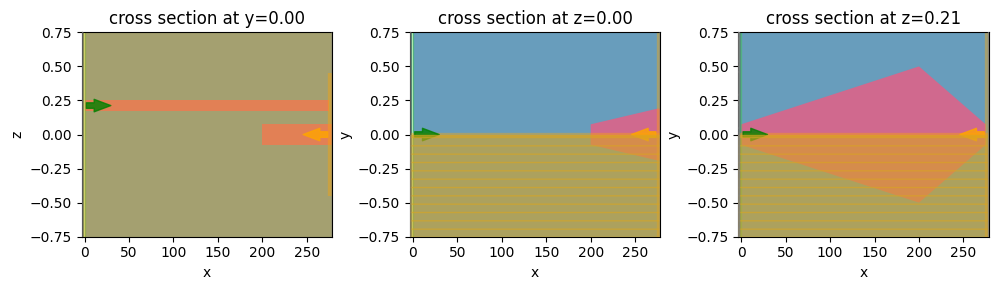

In [7]:
# define simulation domain size
Lx = L_EC + L_tran + 2 * buffer
Ly = 6 * r_core
Lz = 6 * r_core
sim_size = (Lx, Ly, Lz)

run_time = 3e-12  # simulation run time

# construct simulation
sim_te = td.Simulation(
    center=((L_EC + L_tran) / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=12, wavelength=lda0),
    structures=[cladding_SiO2, top_SiN, bottom_SiN, cladding_fiber, core_fiber],
    sources=[fiber_mode],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(0, -1, 0),
)

# plot a few cross sections of the simulation to examine the setup
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
sim_te.plot(y=0, ax=ax1)
ax1.set_ylim(-r_core / 2, r_core / 2)
ax1.set_aspect("auto")

sim_te.plot(z=0, ax=ax2)
ax2.set_aspect("auto")
ax2.set_ylim(-r_core / 2, r_core / 2)

sim_te.plot(z=t_1 / 2 + t_space + t_2 / 2, ax=ax3)
ax3.set_aspect("auto")
ax3.set_ylim(-r_core / 2, r_core / 2)

plt.show()

In addition, we zoom in to the optical fiber region to ensure it is set up correctly.

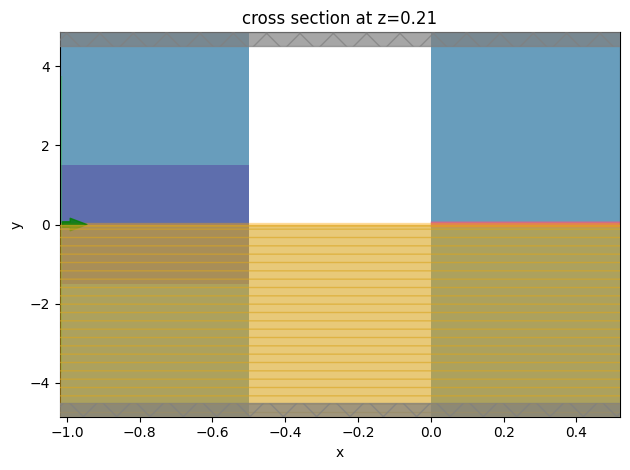

In [8]:
ax = sim_te.plot(z=t_1 / 2 + t_space + t_2 / 2)
ax.set_aspect("auto")
ax.set_xlim(-gap - lda0, lda0)
plt.show()

The TM polarization simulation can be defined by copying the TE simulation and updating the symmetry.

In [9]:
sim_tm = sim_te.copy(update={"symmetry": (0, 1, 0)})
print(f"The simulation contains {sim_tm.num_cells/1e9} billion grid points.")

The simulation contains 1.347661944 billion grid points.


Each simulation contains over **1 billion** grid points since the length of the coupler is over 500 free space wavelengths. For `Tidy3D`, such large simulations can be handled easily.

## Batch Sweeping Different Polarizations

We can run the two simulations sequentially. However, for maximum efficiency, we will run them concurrently by making a simulation [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html). To do so, we first put simulations in a Python dictionary.

In [10]:
sims = {
    "TE": sim_te,
    "TM": sim_tm,
}

Then we submit the simulation as a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) to run on the server.

In [11]:
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

Output()

11:02:02 UTC Started working on Batch containing 2 tasks.

11:02:04 UTC Maximum FlexCredit cost: 26.339 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

11:07:56 UTC Batch complete.

Output()

## Result Visualization

After the simulations are complete, we can calculate and plot the coupling efficiencies. For both polarizations, the coupling losses are below 4 dB in a broad wavelength range, which is a great improvement compared to the simple single-layer edge coupler.

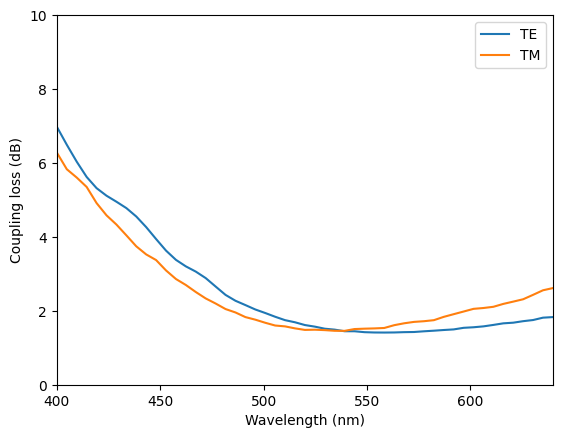

In [12]:
amp_te = batch_results["TE"]["mode"].amps.sel(mode_index=0, direction="+")
T_te = np.abs(amp_te) ** 2

amp_tm = batch_results["TM"]["mode"].amps.sel(mode_index=0, direction="+")
T_tm = np.abs(amp_tm) ** 2

plt.plot(ldas * 1e3, -10 * np.log10(T_te), label="TE")
plt.plot(ldas * 1e3, -10 * np.log10(T_tm), label="TM")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Coupling loss (dB)")
plt.ylim(0, 10)
plt.xlim(np.min(ldas * 1e3), np.max(ldas * 1e3))
plt.legend()
plt.show()

Lastly, we can plot the field norm distribution to visualize the coupling process.

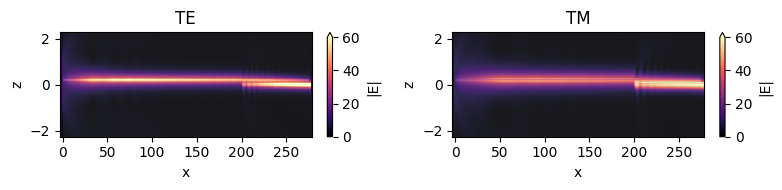

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2), tight_layout=True)
batch_results["TE"].plot_field(
    field_monitor_name="field", field_name="E", val="abs", ax=ax1, vmin=0, vmax=60
)
ax1.set_aspect("auto")
ax1.set_title("TE")

batch_results["TM"].plot_field(
    field_monitor_name="field", field_name="E", val="abs", ax=ax2, vmin=0, vmax=60
)
ax2.set_aspect("auto")
ax2.set_title("TM")
plt.show()